In [11]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import os, certifi
from mtp.mheads._abc import AbstractDisributionHeadConfig
from mtp.mheads import MHEADS
os.environ["SSL_CERT_FILE"] = certifi.where()

In [ ]:
# Make the image binary: threshold at 0.5 after ToTensor, then convert to long (int)
transform = transforms.Compose([transforms.ToTensor(), lambda x: (x > 0.5).long()])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.MNIST(
    "./data", train=True, transform=transform, download=True
)
validation_set = torchvision.datasets.MNIST(
    "./data", train=False, transform=transform, download=True
)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(
    validation_set, batch_size=4, shuffle=False
)

# Report split sizes
print("Training set has {} instances".format(len(training_set)))
print("Validation set has {} instances".format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


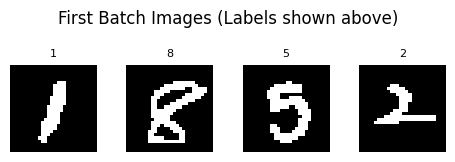

In [ ]:


# Get the first batch from the training loader
dataiter = iter(training_loader)
images, labels = next(dataiter)

# Show up to the first 10 images in the batch using seaborn
num_images = min(10, images.shape[0])
plt.figure(figsize=(num_images * 1.2, 1.5))  # Make images smaller

for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    img = images[i].squeeze().numpy()
    sns.heatmap(img, cmap='gray', cbar=False, xticklabels=False, yticklabels=False, square=True)
    plt.title(f"{labels[i].item()}", fontsize=8)
    plt.axis('off')

plt.suptitle("First Batch Images (Labels shown above)", y=1.05)
plt.tight_layout()
plt.show()


In [ ]:
# HPs
num_epochs = 5
lr = 0.001  

model = MHEADS["moe_proj"](
    AbstractDisributionHeadConfig(
        horizon=784,
        d_model=10,  # 9 digits
        d_output=2,  # 2 classes
        rank=32,
        pos_func='abs',
    )
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
for epoch in range(num_epochs):
    pbar = tqdm(training_loader)
    for batch in pbar:
        y, x = batch  # for gen modelling reverse x, y
        B = x.shape[0]
        z = (
            torch.nn.functional.one_hot(
                x,
                num_classes=10,
            )
            .reshape(B, -1)
            .to(torch.float32)
        )  # (B, 10)
        z, y = z.to(device), y.to(device)
        output = model(z, y.reshape(B, -1))
        loss = output.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        pbar.set_postfix(loss=loss.item())
    print(f"Epoch {epoch+1} | Loss: {loss.item()}")

    # Sample
    model.eval()
    z = torch.nn.functional.one_hot(torch.tensor([0]), num_classes=10).to(torch.float32).to(device)
    y = model.generate(z)
    

  1%|          | 110/15000 [01:14<2:48:23,  1.47it/s, loss=0.713]


KeyboardInterrupt: 

In [ ]:
z = torch.nn.functional.one_hot(torch.tensor([0]), num_classes=10).to(torch.float32).to(device)

In [36]:
# Sample
model = MHEADS["moe_proj"](
    AbstractDisributionHeadConfig(
        horizon=300,
        d_model=10,  # 9 digits
        d_output=2,  # 2 classes
        rank=1,
    )
)
z = torch.nn.functional.one_hot(torch.tensor([0]), num_classes=10).to(torch.float32).to(device)
y = model.generate(z)

RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

In [34]:
y

tensor([[0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
         1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
         1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
         0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
         0, 1, 1, 0]])